<a href="https://www.kaggle.com/code/carolinariddick/eeg-signal-processing-analysis-neuroscience?scriptVersionId=279160800" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# EEG Frequency analysis in EEG

## 1. Data Structure

* EEG data stored in a DataFrame.
* Rows = samples.
* Columns = channels.

## 2. Bandpass Filtering

* Apply a bandpass filter to keep a specific frequency range.
* Output: cleaned EEG signal per channel.

## 3. Fast Fourier Transform (FFT)

* Compute FFT per channel.
* Normalize using: `fft_values = fft_values / data_len`.
* Use only the first half (positive frequencies).
* Frequencies computed with: `frequencies = np.arange(N/2) / (N / sampling_rate)`.

## 4. Nyquist Frequency

* Maximum representable frequency.
* Formula: `Nyquist = sampling_rate / 2`.

## 5. Spectrum (Frequency Domain)

* Compute amplitude: `np.abs(fft_values)`.
* Plot amplitude vs. frequency.
* One spectrum per channel.

## 6. Plotting FFT per Channel

* Use subplots to show all channels.
* Apply consistent colors.
* Limit x-axis (e.g. 0–30 Hz).

## 7. Hilbert Transform

* Compute analytic signal.
* Amplitude envelope = magnitude of analytic signal.
* Shows amplitude modulation over time.

## 8. Plotting Envelope + Filtered Signal

* Plot filtered EEG.
* Plot envelope on the same figure.
* Visualises how the signal intensity changes.

## 9. Wavelet Transform

* Provides time–frequency analysis.
* Shows how frequency content evolves over time.
* Complements FFT and Hilbert.

## 10. General Observations

* FFT = global frequencies.
* Hilbert = amplitude modulation.
* Wavelet = local time–frequency information.


## Import libraries

To install libraries in Python, you can use a package manager like pip, which comes pre-installed with most Python distributions.

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import scipy
from scipy import signal
!pip install PyWavelets --quiet
import pywt

## Import Dataset

In [2]:
# load the Excel file as a DataFrame
eeg_data = pd.read_excel("/kaggle/input/dataset-with-channels-for-eeg-visualization/dataset.xlsx")
display(eeg_data.head())

,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8
0,23899.1,2951.1,36442.2,38418.6,12414.9,3759.5,31001.4,52775.3
1,23917.7,3048.0,36463.8,38344.3,12448.1,3726.3,31032.4,52223.4
2,23984.9,3148.2,36525.1,39002.6,12520.4,3601.3,31103.2,53175.1
3,24016.8,3183.3,36551.5,39602.8,12548.5,3473.0,31133.2,54514.6
4,23960.3,3061.0,36494.8,39256.9,12475.6,3549.7,31061.9,54321.3


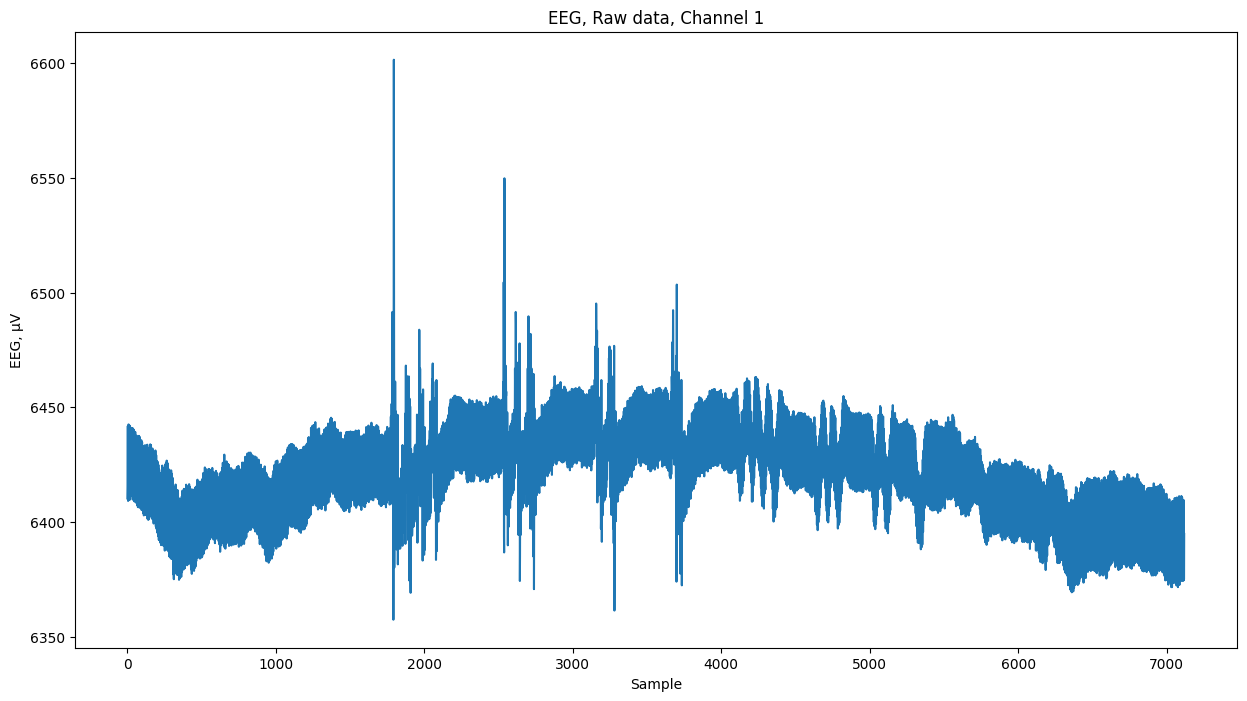

In [3]:
# select the data from the first channel
channel = 0
channel_data = eeg_data.iloc[:, channel]

# convert from Digital Value of Analog Digital converter (ADC) ADS1299 to microvolts µV
channel_data = round(1000000*4.5*(channel_data/16777215),2)

# plot the EEG data
plt.figure(figsize=(15,8))
plt.plot(channel_data)
plt.title("EEG, Raw data, Channel " +str(channel + 1))
plt.ylabel('EEG, µV')
plt.xlabel('Sample')
plt.show()

## Band Pass Filter

Band-pass filtering is a common signal processing technique used in EEG (Electroencephalography) data analysis to isolate specific frequency bands of interest while removing unwanted frequencies. Band-pass filtering allows researchers to focus on particular brainwave rhythms that are relevant to their study. For example, you might want to extract the alpha, beta, or gamma waves from the EEG data.  

You can read more about the band-pass filter in [Chapter 1](https://graceful-kelpie-579688.netlify.app/chapters/chapter_1-band_pass_filter).

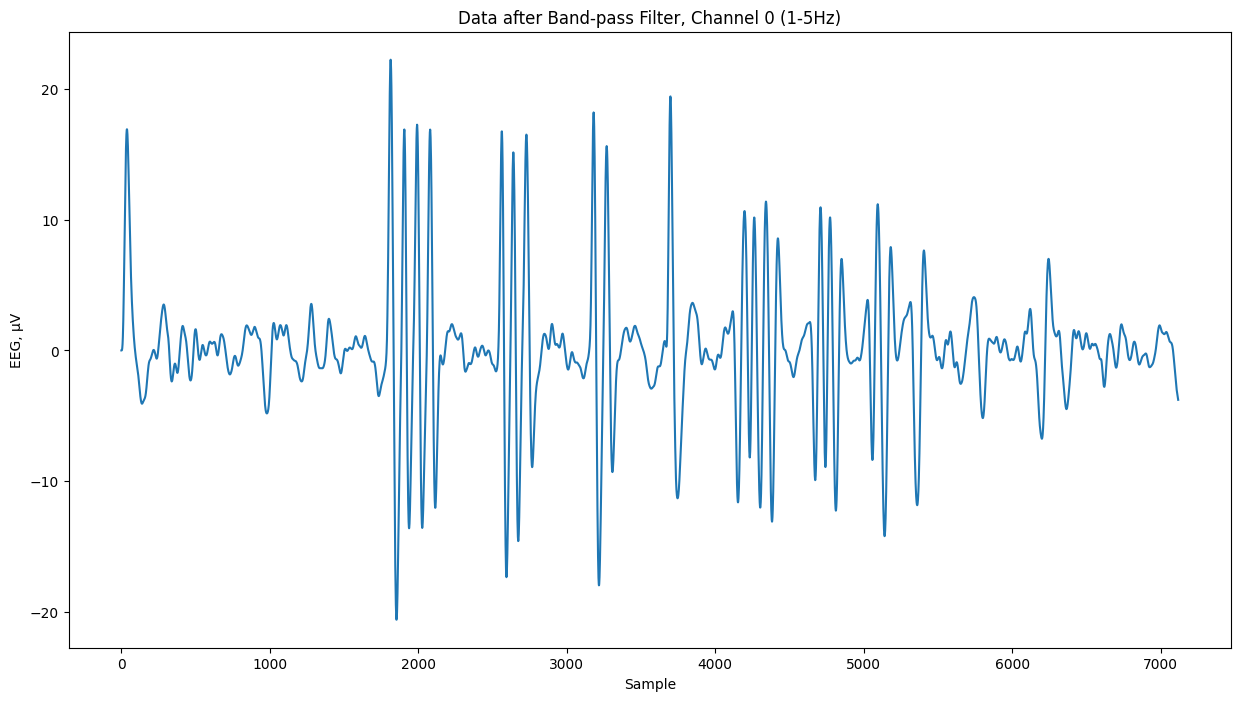

In [4]:
def butter_highpass_filter(data, cutoff, nyq, order=5):
    """Butterworth high-pass filter.
    Args:
        data (array_like): data to be filtered.
        cutoff (float): cutoff frequency.
        order (int): order of the filter.
    Returns:
        array: filtered data."""
    normal_cutoff = cutoff / nyq  # normalized cutoff frequency
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    filtered_data = signal.filtfilt(b, a, data)
    return filtered_data

def butter_lowpass_filter(data, cutoff, nyq, order=5):
    """Butterworth low-pass filter.
    Args:
        data (array_like): data to be filtered.
        cutoff (float): cutoff frequency.
        order (int): order of the filter.
    Returns:
        array: filtered data."""
    normal_cutoff = cutoff / nyq  # normalized cutoff frequency
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = signal.lfilter(b, a, data)
    return filtered_data

channel_data_bp_filtered = channel_data.copy()  # copy the data
fps = 250  # sampling frequency
cutoff_high = 1  # cutoff frequency of the high-pass filter
cutoff_low = 5  # cutoff frequency of the low-pass filter
nyq = 0.5 * fps  # Nyquist frequency (half of the sampling frequency)

# apply the band-pass filter
channel_data_bp_filtered = butter_highpass_filter(
    data=channel_data_bp_filtered,
    cutoff=cutoff_high,  # high-pass filter
    nyq=nyq,
    order=5)
channel_data_bp_filtered = butter_lowpass_filter(
    data=channel_data_bp_filtered,
    cutoff=cutoff_low,  # low-pass filter
    nyq=nyq,
    order=4)

plt.figure(figsize=(15,8))
plt.plot(channel_data_bp_filtered)
plt.title(f"Data after Band-pass Filter, Channel {channel} " + "("+str(cutoff_high)+"-"+str(cutoff_low) + "Hz)")
plt.ylabel('EEG, µV')
plt.xlabel('Sample')
plt.show()

## Frequency analysis

Frequency analysis for EEG is a fundamental technique that unveils the distribution of different frequency components within the brain's electrical activity. This analysis involves the transformation of EEG signals from the time domain to the frequency domain, typically using the Fast Fourier Transform (FFT) algorithm. This transformation allows us to observe the intensity and prevalence of specific frequency bands, such as delta (0.5-4 Hz), theta (4-8 Hz), alpha (8-13 Hz), beta (13-30 Hz), and gamma (30-100 Hz) waves.

Each frequency band corresponds to distinct neural processes and cognitive states. For instance, delta waves are associated with deep sleep and unconsciousness, while alpha waves often indicate relaxed wakefulness. Beta waves are linked to active cognition and alertness, while gamma waves are connected to high-level information processing. Frequency analysis helps identify anomalies or irregularities in these patterns, aiding in the diagnosis of neurological conditions like epilepsy, sleep disorders, and cognitive impairments.


### Fast Fourier Transform (FFT)

FFT is a widely used method in signal processing and is particularly valuable in the field of neurophysiology for studying the frequency components present in EEG signals.

**Positive**

*  **Frequency Representation:** EEG signals consist of complex patterns of neural oscillations at different frequencies. FFT breaks down these signals into their constituent frequency components, revealing the dominant frequencies present in the data.

* **Feature Extraction:** FFT generates a frequency spectrum that can be used for feature extraction. Different frequency bands (delta, theta, alpha, beta, gamma) are associated with distinct cognitive and neural processes, enabling the extraction of relevant features for analysis.

* **Brain Rhythms**: EEG signals are characterized by rhythmic patterns linked to brain functions. FFT enables the identification and quantification of these rhythmic components, aiding in the study of brain states and processes.

* **Event-Related Potentials (ERPs):** FFT can be applied to segmented EEG epochs to examine event-related potentials, revealing time-locked neural responses to specific stimuli or events in the frequency domain.

* **Spectral Analysis:** FFT provides power spectral density estimates, helping to analyze the distribution of signal power across different frequency bands and their variations over time or experimental conditions.

* **Artifact Detection:** FFT can help in detecting and addressing artifacts in EEG data. Artifacts often appear as broadband frequency components, making them distinguishable from genuine neural oscillations.

* **Temporal Resolution:** While EEG has excellent temporal resolution, it lacks frequency-specific information. FFT adds frequency specificity while preserving the time information, offering a comprehensive view of EEG signals.

**Negative**

*   **Temporal Resolution:** FFT sacrifices temporal resolution to provide frequency information. This can lead to a loss of information regarding rapid changes and dynamic interactions between neural oscillations, which are crucial for understanding certain cognitive processes.

*  **Frequency Leakage:** FFT assumes that signals are periodic and stationary, which may not hold true for EEG data. This can result in "frequency leakage," where spectral energy can spread across adjacent frequency bins, making it challenging to accurately isolate specific frequency components.

*  **Windowing Effects:** Applying FFT to short segments of EEG data, a common practice for event-related analysis, introduces windowing effects that can distort frequency representations, particularly for high-frequency oscillations.

*  **Non-Stationarity:** EEG signals can exhibit non-stationarity, where frequency content changes over time. FFT assumes stationary signals, which can lead to misinterpretations of dynamic changes in neural activity.

*  **Artifact Influence:** EEG signals often contain artifacts (e.g., eye blinks, muscle activity) that can introduce spurious frequency components. FFT might not effectively separate these artifacts from genuine neural oscillations.

*  **Choosing Frequency Bands:** Dividing EEG signals into predefined frequency bands using FFT might not capture individual variability in frequency ranges and can lead to arbitrary or oversimplified interpretations.

**How it works**  

FFT is a mathematical algorithm that converts time-domain EEG signals into the frequency domain. It does this by breaking down the EEG data into its constituent sinusoidal frequency components, revealing the strength of each frequency's presence in the signal. This process helps identify dominant frequencies and their distribution, offering insights into the underlying neural oscillations present in the EEG data.




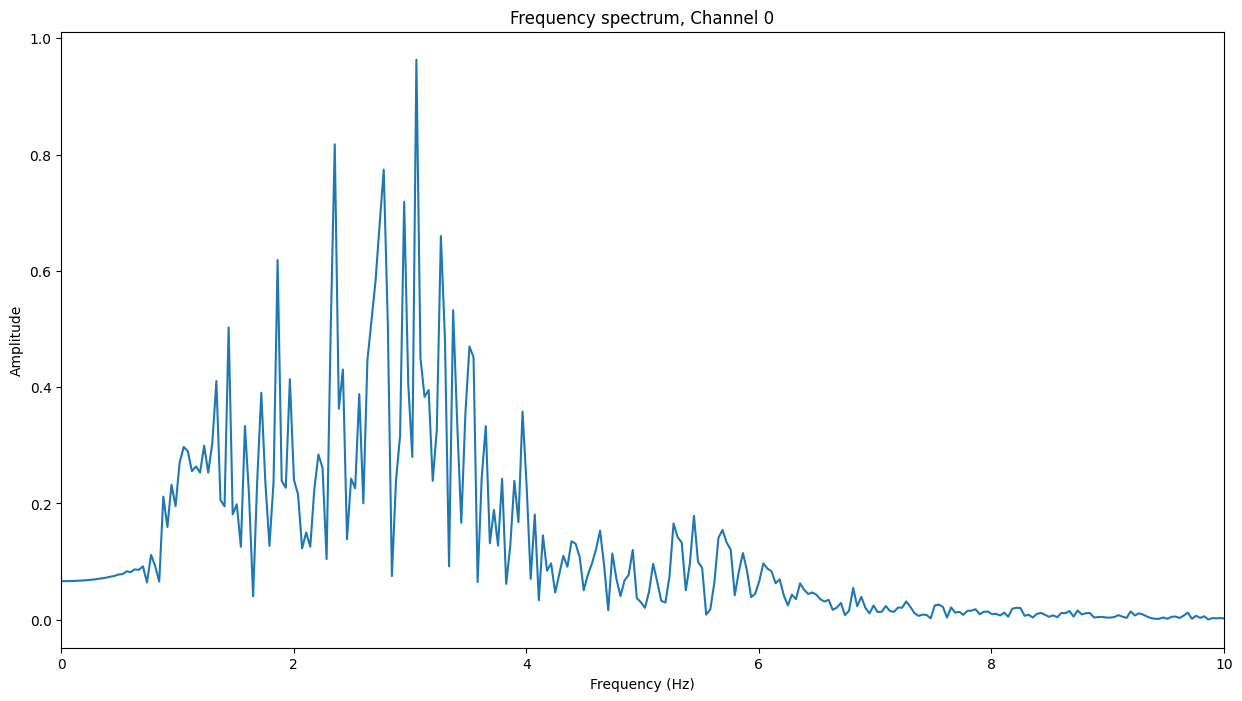

In [5]:
# Number of observations/samples (7120)
data_len = len(channel_data_bp_filtered) 

# Compute FFT. This will give us the different type of EEG frequencies.
fourier_transform = np.fft.fft(channel_data_bp_filtered)

# Normalize values to get the corresponding number according to the samples
fourier_transform = fourier_transform / data_len

# Take half of the data since the other half of the data is unused for EEG (this other half has negative values, thats why we get rid of them)
fourier_transform = fourier_transform[:int(data_len/2)] # is the same as doing this [:int(7120/2)] => [:3560]

# Time period of the signal (aprox 28 segs)
time_period = data_len / fps 

# x-axis values up to Nyquist frequency
values = np.arange(int(data_len/2))

# x-axis values in Hz
frequencies = values / time_period

plt.figure(figsize=(15,8))
plt.plot(frequencies, 
         abs(fourier_transform))

plt.title(f"Frequency spectrum, Channel {channel}")
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.xlim([0, 10])
plt.show()

### Let's plot all the channels and their FFT frequencies

In [6]:
# convert all the datam from Digital Value of Analog Digital converter (ADC) ADS1299 to microvolts µV
eeg_data_converted = round(1000000*4.5*(eeg_data/16777215),2)
# eeg_data_converted

In [7]:
eeg_data_bp_filtered = eeg_data_converted.copy()  # copy the data

fps = 250  
cutoff_high = 1 
cutoff_low = 5 
nyq = 0.5 * fps

In [8]:
# apply the band-pass filter

for channel in range(eeg_data.shape[1]):
    # high-pass filter
    eeg_data_bp_filtered.iloc[:, channel] = butter_highpass_filter(
        data=eeg_data.iloc[:, channel],
        cutoff=cutoff_high,
        nyq=nyq,
        order=5)
    
    # low-pass filter
    eeg_data_bp_filtered.iloc[:, channel] = butter_lowpass_filter(
        data=eeg_data_bp_filtered.iloc[:, channel],
        cutoff=cutoff_low,
        nyq=nyq,
        order=4)

# This is the egg_data after the pass band filter
# eeg_data_bp_filtered

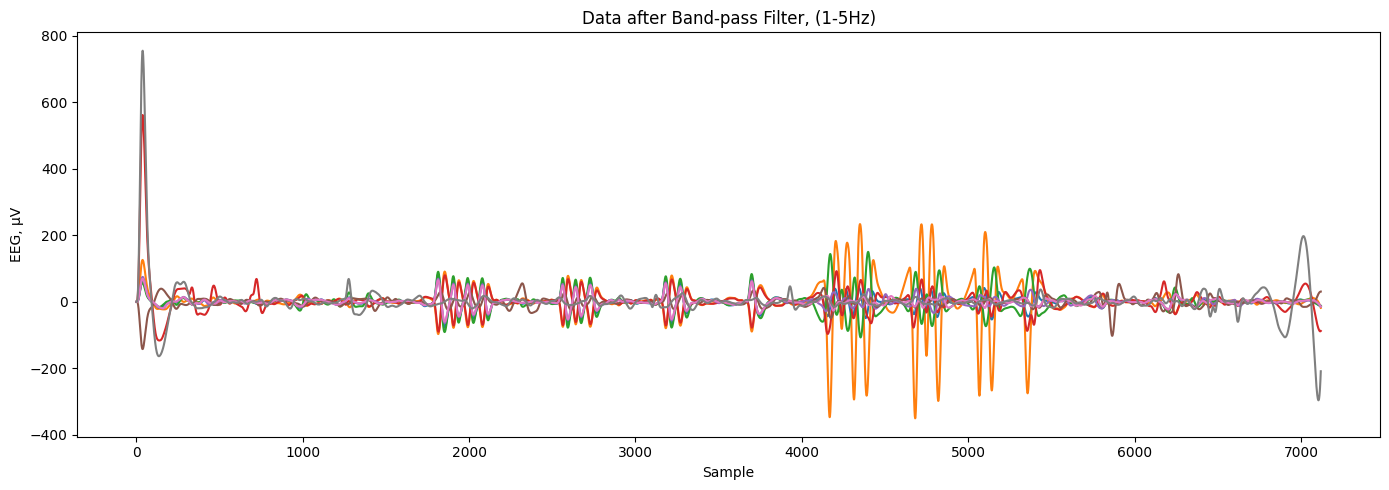

In [9]:
plt.figure(figsize=(14, 5))
plt.plot(eeg_data_bp_filtered)
plt.title("Data after Band-pass Filter, ("+str(cutoff_high)+"-"+str(cutoff_low) + "Hz)")
plt.ylabel('EEG, µV')
plt.xlabel('Sample')
plt.tight_layout()
plt.show()

In [10]:
set_of_colors = [
    '#1f77b4',  # blue
    '#ff7f0e',  # orange
    '#2ca02c',  # green
    '#d62728',  # red
    '#9467bd',  # violet
    '#8c564b',  # brown
    '#e377c2',  # pink
    '#7f7f7f'   # grey
]

In [11]:
def fft_process_data(eeg_data):
    data_len = len(eeg_data)
    fps = 250 
    fft_result = {}

    for channel in eeg_data.columns:
        
        # Compute FFT
        fourier_transform = np.fft.fft(eeg_data[channel])
        
        # Normalize
        fourier_transform = fourier_transform / data_len
        
        # Keep only positive frequencies
        fourier_transform = fourier_transform[:data_len//2]

        # Save result for this channel
        fft_result[channel] = fourier_transform 

    # Compute frequencies only once
    time_period = data_len / fps
    values = np.arange(data_len//2)
    frequencies = values / time_period

    return frequencies, pd.DataFrame(fft_result)

In [12]:
fft_frequency_data = eeg_data_converted.copy()

# we will save the new values here
frequencies, fft_frequency_data = fft_process_data(eeg_data_converted)

# print(frequencies.shape)
fft_magnitude = fft_frequency_data.apply(np.abs)

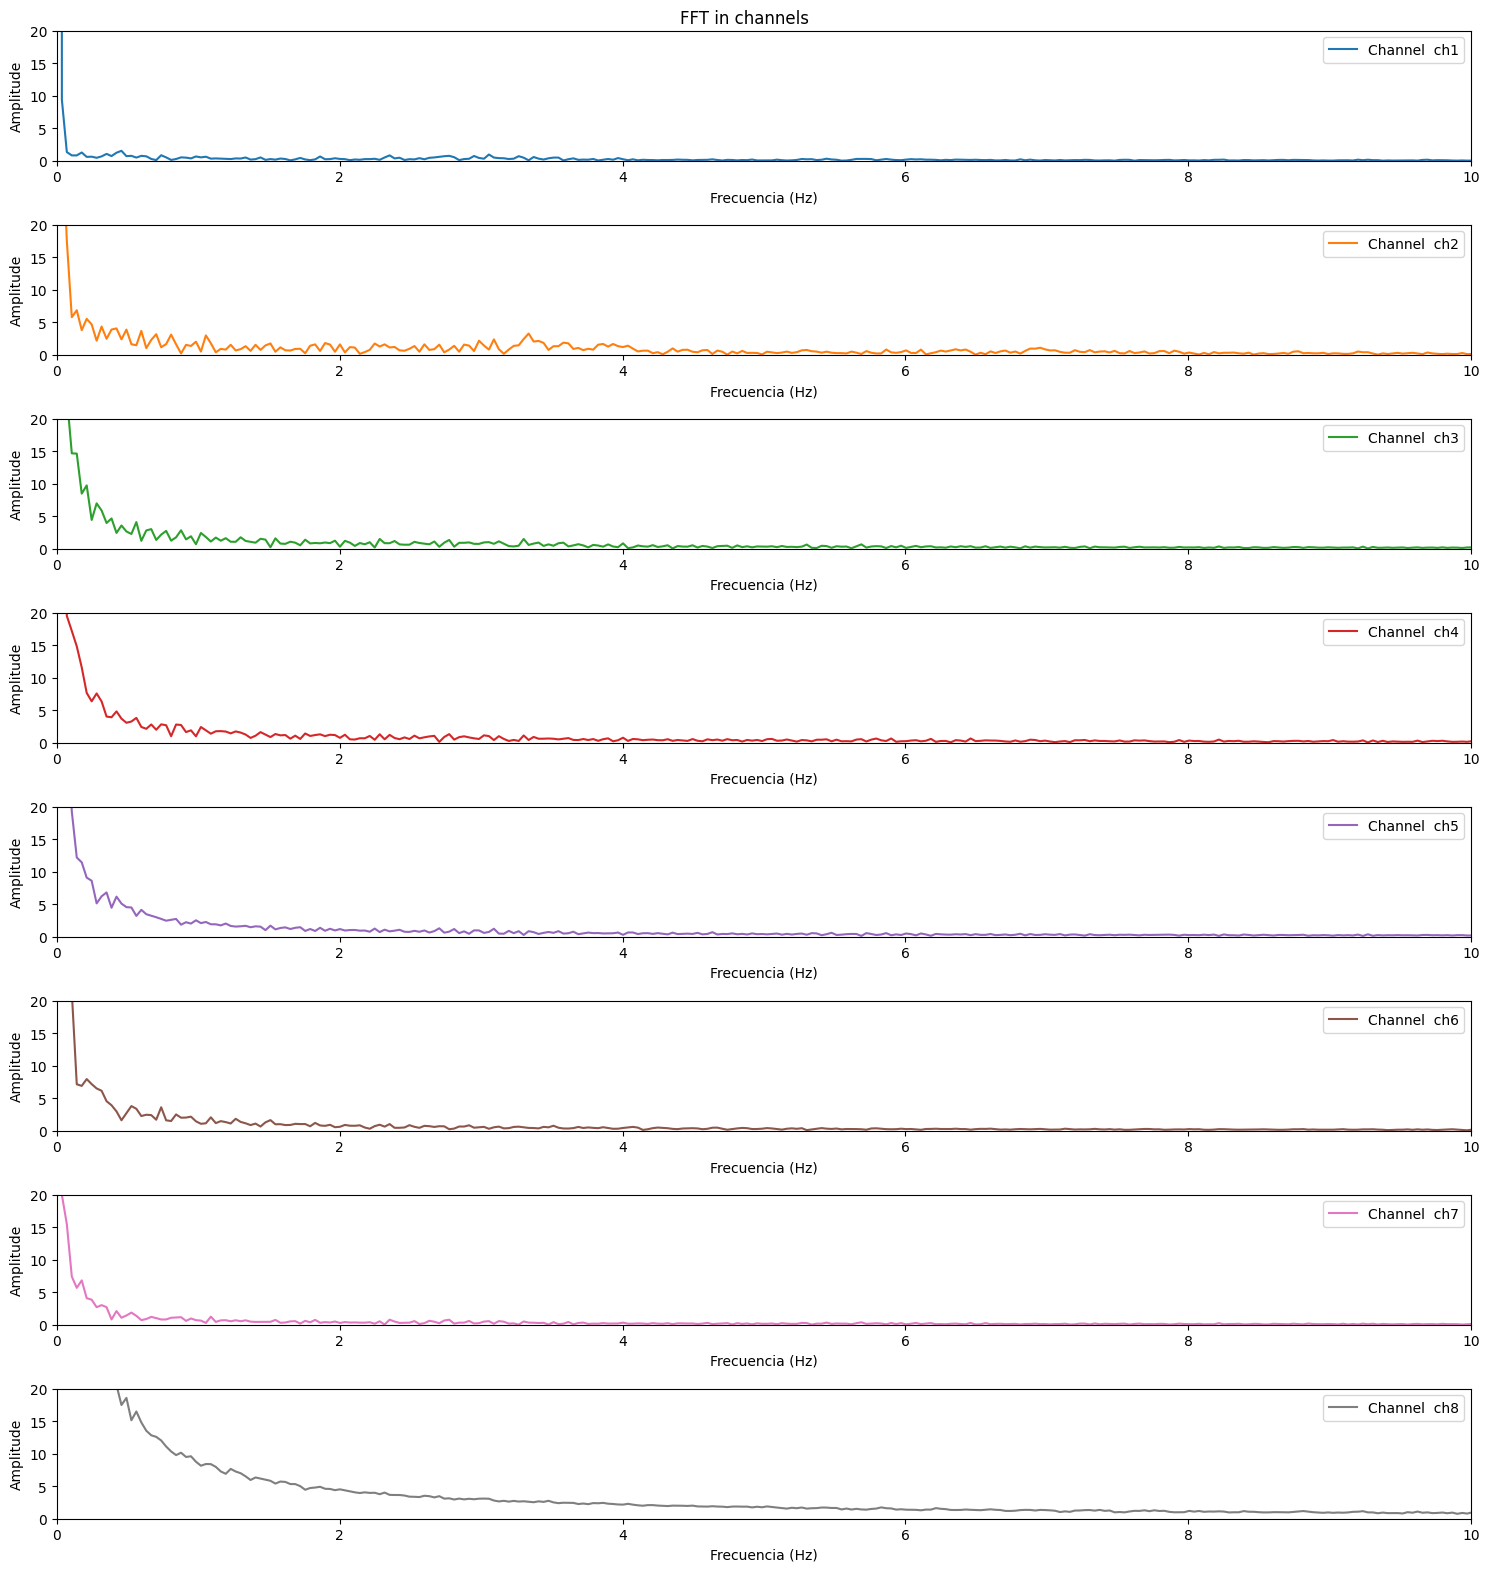

In [13]:
fig, axs = plt.subplots(8, 1, figsize=(15, 16))


for i, channel in enumerate(fft_magnitude.columns):
    axs[i].plot(
        frequencies,
        fft_magnitude[channel], 
        c=set_of_colors[i],
        label=f'Channel {channel}' )     
           
    axs[i].set_xlabel("Frecuencia (Hz)")
    axs[i].set_ylabel('Amplitude')
    axs[i].set_xlim([0, 10])
    axs[i].set_ylim([0, 20])
    axs[i].legend()

plt.suptitle('FFT in channels')

plt.tight_layout()
plt.show()

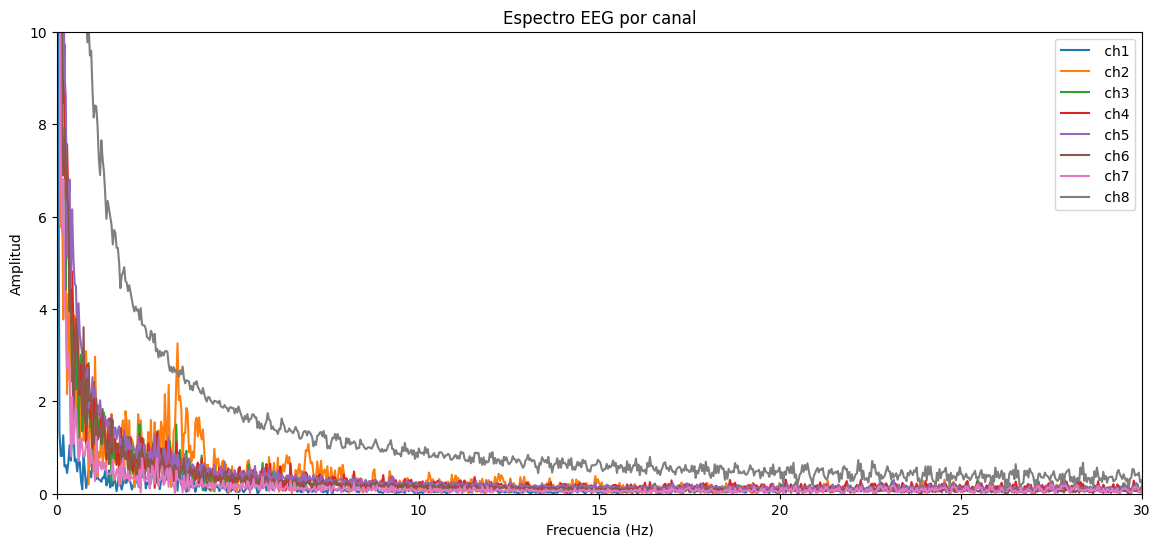

In [14]:
# Plot all the channels in one single plot
plt.figure(figsize=(14,6))
for channel in fft_magnitude.columns:
    plt.plot(frequencies, fft_magnitude[channel], label=channel)

plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Amplitud")
plt.title("Espectro EEG por canal")
plt.legend()
plt.xlim([0, 30])
plt.ylim([0, 10])
plt.show()

**Expected Observations and Discussion**

*   **1-10 Hz Filter:** This filter will allow frequencies between 1 and 10 Hz to pass through while attenuating frequencies outside this range. The frequency spectrum will show prominent peaks around the 5 Hz and 10 Hz components.
*   **5-15 Hz Filter:** This filter will allow frequencies between 5 and 15 Hz to pass through while attenuating frequencies outside this range. The frequency spectrum will show prominent peaks around the 5 Hz, 10 Hz, and possibly 15 Hz components.

*   **Shorter Length (1000 samples):** Shorter data length results in lower frequency resolution, leading to broader peaks in the frequency spectrum. The overall detail in the frequency domain will be less precise.
  
*   **Longer Length (6000 seconds):** Longer data length provides higher frequency resolution, leading to sharper and more defined peaks in the frequency spectrum. The overall detail in the frequency domain will be more precise.

### Wavelet tranform

Wavelet transform is another useful technique for dimensionality reduction in EEG data. It is particularly effective when dealing with time-frequency analysis, allowing the extraction of relevant time-frequency features from EEG signals.

**Positive**

* Time-Frequency Localization: Wavelet transform provides a localized representation of frequency content over time. This enables the identification of transient changes in neural activity and frequency modulation that might be missed by methods focused solely on time or frequency.

* Multiresolution Analysis: Wavelet transform decomposes EEG signals into different scales, revealing details at various levels. This allows for a selective representation of signal components, effectively highlighting relevant patterns while reducing noise.

* Adaptation to Non-Stationarity: EEG signals often exhibit non-stationarity, with frequency characteristics changing over time. Wavelet's variable-sized window can adapt to these changes, ensuring accurate representation of dynamic neural processes.

* Sparse Representation: In wavelet decomposition, only a subset of coefficients is significant, resulting in a sparse representation. This sparsity can be leveraged for efficient dimensionality reduction while preserving essential signal characteristics.

* Artifact Removal: Wavelet denoising techniques can effectively remove noise and artifacts from EEG data, enhancing the signal-to-noise ratio and improving the quality of data used for subsequent analyses.

* Visualization: Wavelet scalograms provide a visual representation of time-frequency dynamics, aiding in the identification of patterns and changes in neural oscillations.

* Customization: Wavelet analysis offers a range of wavelet functions and scales that can be tailored to the specific characteristics of EEG data and research questions, enhancing flexibility and adaptability.

**Negative**

* Feature Extraction Overload: Wavelet coefficients generated from different scales can result in a large number of features. If not managed carefully, this abundance of features can lead to overfitting and reduced interpretability.

* Subjectivity in Wavelet Selection: The choice of wavelet function and decomposition levels can be subjective and influence the outcomes. Different choices might yield varying results, leading to difficulties in reproducibility.

* Loss of Temporal Detail: While Wavelet transform captures time-frequency information, it might not retain fine-grained temporal details as effectively as time-domain methods. This could be a limitation when preserving precise timing is crucial.

* Non-Linear Relationships: Wavelet transform assumes linear relationships between the different scales and levels of EEG data, which might not hold true in all cases. This could lead to oversimplification of complex neural interactions.

* Choice of Scaling Functions: Different wavelet functions are suited for different types of signals. Selecting an inappropriate wavelet could result in a poor representation of the EEG data, leading to suboptimal dimensionality reduction.

**How it works**  

Wavelet transform is a mathematical technique that analyzes EEG data by decomposing it into different frequency components over time. It involves using a set of wavelet functions, which are like filters of varying scales, to capture both the time and frequency characteristics of the data. By applying these wavelets, the original EEG signal is transformed into a representation where different scales reveal different frequency information. This approach is useful for understanding how frequencies change over time, which is important in capturing the dynamic nature of EEG signals.


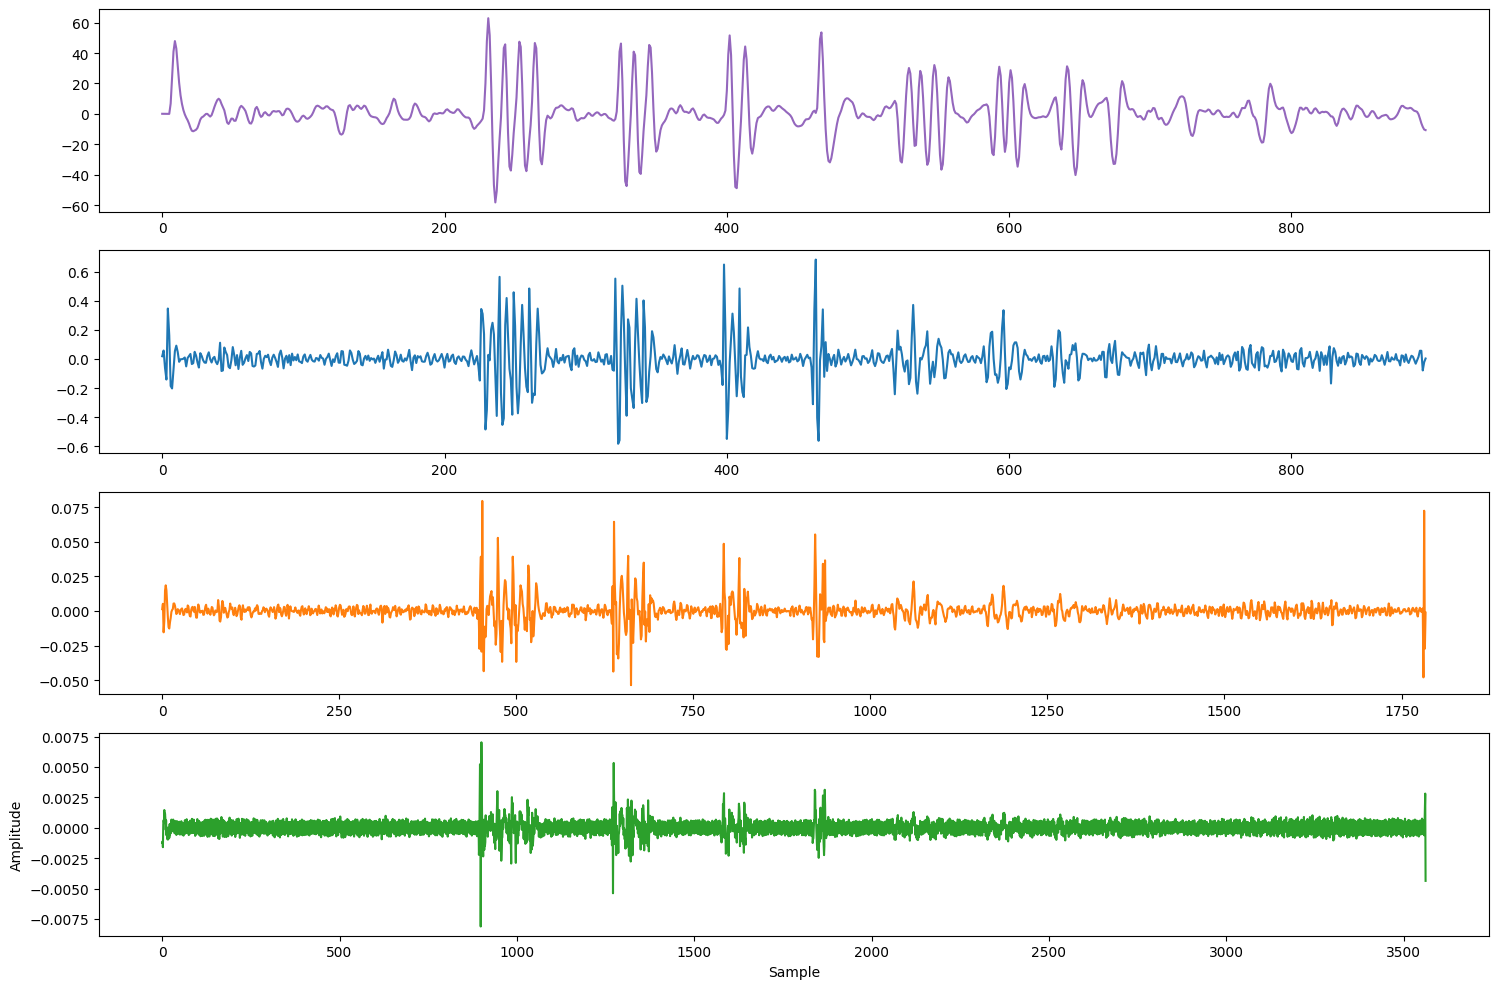

In [15]:
# define wavelet function and decomposition level
wavelet = 'db4'
level = 3

# perform wavelet decomposition
coeffs = pywt.wavedec(channel_data_bp_filtered, 
                      wavelet, 
                      level=level)

# plot wavelet coefficients
fig, axs = plt.subplots(level+1, 1, 
                        figsize=(15, 10))

# plot approximation coefficients
axs[0].plot(coeffs[0], 
           set_of_colors[4])
axs[3].set_ylabel('Amplitude')

# plot detail coefficients
for i, detail_coeffs in enumerate(coeffs[1:]):
    axs[i+1].plot(detail_coeffs, 
                  set_of_colors[i])

axs[-1].set_xlabel('Sample')
plt.tight_layout()
plt.show()

*   Approximation Coefficients: These will be blocky and may resemble step functions due to the non-smooth nature of the Haar wavelet.
*   Detail Coefficients: These will also be less smooth and may capture abrupt changes or edges in the signal more prominently.
*   Overall Plot: The plots will look less smooth and more like a series of jumps or steps, reflecting the nature of the Haar wavelet's basis functions.

**Expected Observations and Discussion**

*   Approximation Coefficients: These will still capture the overall trend, but the higher-level details will be more pronounced.
*   Detail Coefficients: There will be more sets of detail coefficients (D1 through D6), with each set representing increasingly finer details. The higher levels (D4, D5, D6) will capture very subtle features of the signal.
*   Overall Plot: The plots will show a detailed approximation and more levels of detail, providing a more granular breakdown of the signal.

## Hilbert transform  

The Hilbert transform is a signal processing technique used to compute the analytic signal of a real-valued time-domain signal. The analytic signal provides the amplitude and instantaneous phase information of the original signal. Hilbert transform is widely used in EEG (Electroencephalography) data analysis to obtain the instantaneous phase and amplitude of brain oscillations, especially in the context of time-frequency analysis.

**Positive**  

* Time-Frequency Analysis: EEG signals often contain oscillatory components that vary in amplitude and frequency over time. The Hilbert transform can be used to compute the instantaneous amplitude and phase of these oscillations at each time point, enabling detailed time-frequency analysis of brain activity.
* Phase-Amplitude Coupling: The Hilbert transform can uncover relationships between the phase of one frequency band and the amplitude of another. This is useful for investigating phase-amplitude coupling, which is implicated in various cognitive functions and neuronal communication.
* Cross-Frequency Coupling: EEG signals often exhibit interactions between different frequency bands, known as cross-frequency coupling. The Hilbert transform aids in quantifying these interactions, shedding light on complex neural dynamics.
* Improved Signal Interpretation: Extracting the instantaneous phase can help differentiate between phase-locked and non-phase-locked components in EEG data, enhancing the interpretation of neural responses.
* Connectivity Analysis: The Hilbert transform is a fundamental tool for connectivity analysis, enabling the assessment of functional connectivity between brain regions by comparing phase relationships across electrodes.

**Negative**  

* Filtering Artifacts: Applying filters before the Hilbert transform can introduce phase distortion and affect the accuracy of the extracted phase information. The choice of filter parameters and the potential introduction of filter artifacts should be carefully considered.
* Phase Ambiguity: The Hilbert transform does not distinguish between positive and negative phase angles, leading to phase ambiguity. This can affect interpretations of phase relationships, particularly when analyzing cross-frequency coupling.
* Amplitude Modulation: The Hilbert transform assumes a sinusoidal waveform for the signal, which might not accurately capture complex waveform shapes, including amplitude modulations that are present in some EEG components.
* Low Signal-to-Noise Ratio: The Hilbert transform can be sensitive to noise and artifacts in EEG data. When the signal-to-noise ratio is low, extracted phase and amplitude information might be unreliable or biased.
* Frequency Mixing: The Hilbert transform assumes that the signal consists of a single dominant frequency. When multiple frequency components are present, the Hilbert transform can mix their phase and amplitude information, leading to inaccuracies.
* Time Smoothing: Applying the Hilbert transform inherently involves a degree of time smoothing, which can obscure rapid changes in the data and potentially mask important transient neural events.

**How it works**  

The Hilbert transform is a mathematical technique used in EEG analysis to extract time-varying amplitude and phase information from oscillatory signals. It transforms a real-valued signal into a complex signal by adding a 90-degree phase-shifted component. This complex representation allows for the separation of amplitude and phase, aiding in tasks like time-frequency analysis, phase-amplitude coupling, and connectivity studies.

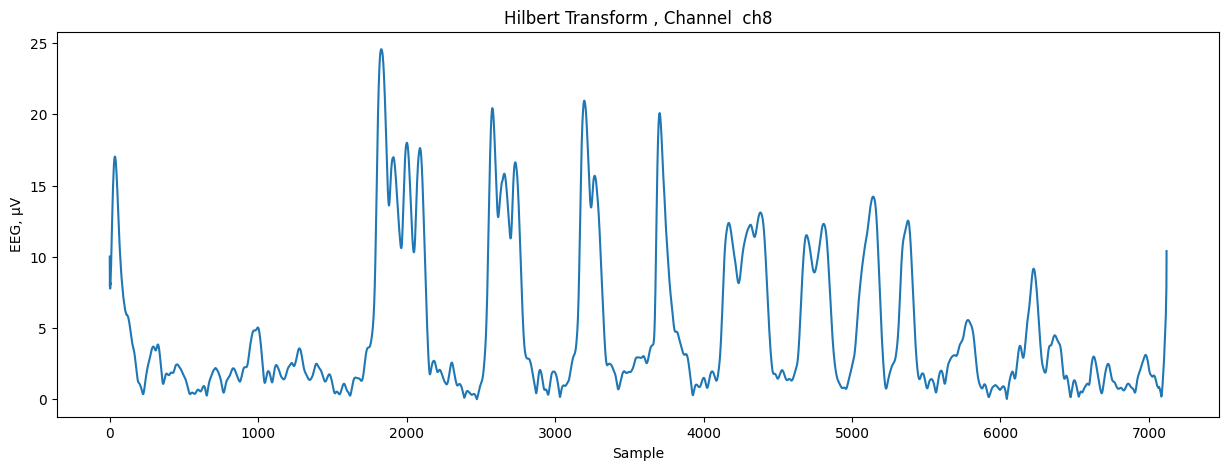

In [16]:
# Apply Hilbert transform

analytic_signal = scipy.signal.hilbert(channel_data_bp_filtered)  
amplitude_envelope = np.abs(analytic_signal)  # compute amplitude envelope

# plot the amplitude envelope
plt.figure(figsize=(15, 5))
plt.plot(amplitude_envelope)
plt.title(f"Hilbert Transform , Channel {channel}")
plt.ylabel('EEG, µV')
plt.xlabel('Sample')
plt.show()

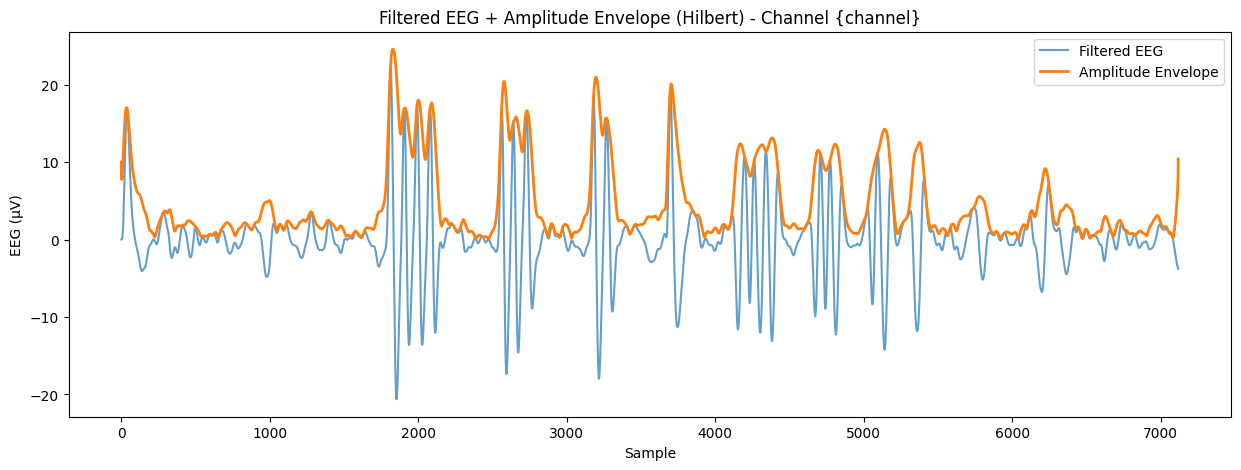

In [17]:
# Hilbert transform → amplitude envelope
analytic_signal = scipy.signal.hilbert(channel_data_bp_filtered)
amplitude_envelope = np.abs(analytic_signal)

# Plot original bandpass-filtered signal + amplitude envelope
plt.figure(figsize=(15, 5))
plt.plot(channel_data_bp_filtered, label='Filtered EEG', alpha=0.7)
plt.plot(amplitude_envelope, label='Amplitude Envelope', linewidth=2)
plt.title("Filtered EEG + Amplitude Envelope (Hilbert) - Channel {channel}")
plt.ylabel('EEG (µV)')
plt.xlabel('Sample')
plt.legend()
plt.show()


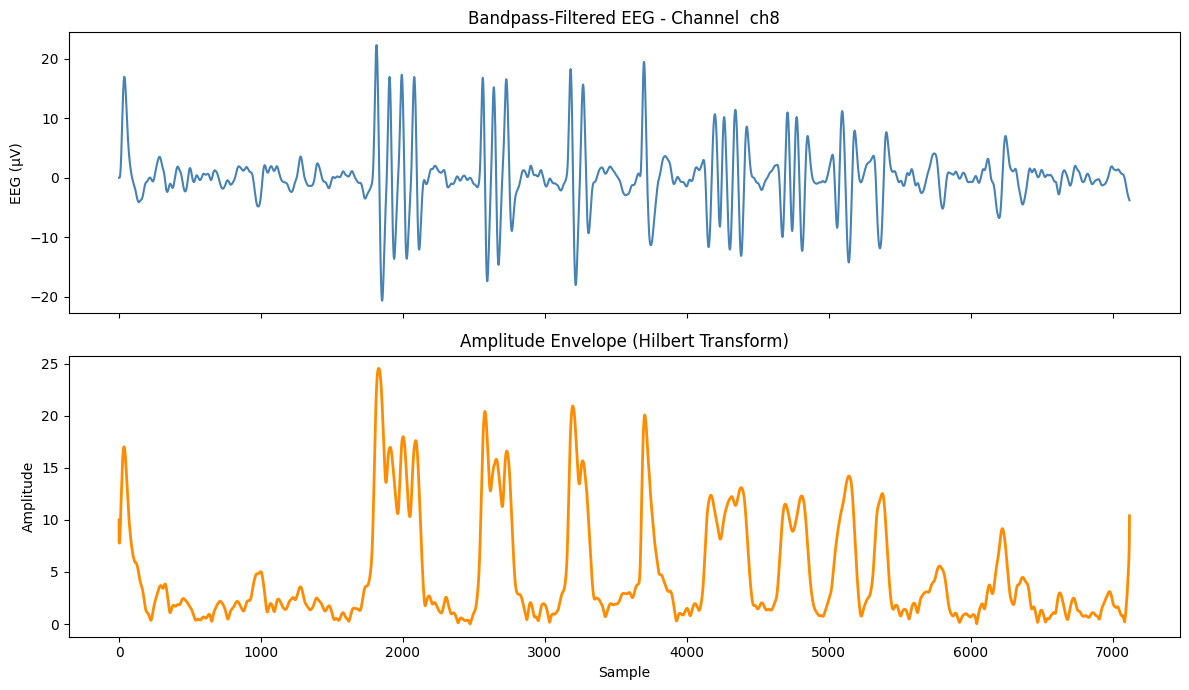

In [18]:
analytic_signal = scipy.signal.hilbert(channel_data_bp_filtered)
amplitude_envelope = np.abs(analytic_signal)

fig, axs = plt.subplots(2, 1, figsize=(12, 7), sharex=True)

# Subplot 1: Señal filtrada
axs[0].plot(channel_data_bp_filtered, color='steelblue')
axs[0].set_title(f"Bandpass-Filtered EEG - Channel {channel}")
axs[0].set_ylabel("EEG (µV)")

# Subplot 2: Envelope
axs[1].plot(amplitude_envelope, color='darkorange', linewidth=2)
axs[1].set_title("Amplitude Envelope (Hilbert Transform)")
axs[1].set_ylabel("Amplitude")
axs[1].set_xlabel("Sample")

plt.tight_layout()
plt.show()
